In [47]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph



Note: you may need to restart the kernel to use updated packages.


In [48]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [49]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

In [50]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [51]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [52]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)


In [53]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, )

all_splits = text_splitter.split_documents(docs)

_ = vector_store.add_documents(documents=all_splits)


In [54]:
prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

/Users/saikeerthanpalavarapu/Documents/projects/llm_/venv/lib/python3.13/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [55]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is a technique used to break down complex tasks into smaller, simpler steps, allowing a model to "think step by step" and utilize more test-time computation. This process transforms big tasks into manageable tasks and provides insight into the model's thinking process.


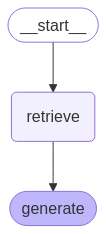

In [56]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))



In [57]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='2801cdd8-2339-4bb2-baa3-eb4a60177d30', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='eaad6e3f-f231-46a8-9e59-ad25543ca303', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One:

In [58]:
vector_store.__dict__

{'_client_settings': Settings(environment='', chroma_api_impl='chromadb.api.segment.SegmentAPI', chroma_server_nofile=None, chroma_server_thread_pool_size=40, tenant_id='default', topic_namespace='default', chroma_server_host=None, chroma_server_headers=None, chroma_server_http_port=None, chroma_server_ssl_enabled=False, chroma_server_ssl_verify=None, chroma_server_api_default_path=<APIVersion.V2: '/api/v2'>, chroma_server_cors_allow_origins=[], is_persistent=False, persist_directory='./chroma', chroma_memory_limit_bytes=0, chroma_segment_cache_policy=None, allow_reset=False, chroma_auth_token_transport_header=None, chroma_client_auth_provider=None, chroma_client_auth_credentials=None, chroma_server_auth_ignore_paths={'APIVersion.V2': ['GET'], 'APIVersion.V2/heartbeat': ['GET'], 'APIVersion.V2/version': ['GET'], 'APIVersion.V1': ['GET'], 'APIVersion.V1/heartbeat': ['GET'], 'APIVersion.V1/version': ['GET']}, chroma_overwrite_singleton_tenant_database_access_from_auth=False, chroma_serve

In [59]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| Decom|position| is| the| process| of| breaking| down| a| complex| task| into| smaller| and| simpler| steps|,| allowing| the| model| to| think| step| by| step| and| utilize| more| test|-time| computation|.| This| technique|,| also| known| as| Chain| of| Thought|,| transforms| big| tasks| into| multiple| manageable| tasks| and| provides| insight| into| the| model|'s| thinking| process|.||